In [53]:
import pandas as pd
import pickle
%matplotlib inline
import numpy as np
import seaborn as sns
from time import time
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
import warnings
import lifelines as ll
from yellowbrick.classifier import DiscriminationThreshold
from lifelines import KaplanMeierFitter
from matplotlib.pyplot import figure
from matplotlib.pyplot import NullFormatter
from lifelines.statistics import logrank_test
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from IPython.display import HTML
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")
from ipywidgets import widgets
from collections import Counter
from sklearn.metrics import auc
import statsmodels.formula.api as sm
from sklearn.metrics import roc_curve
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
#import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split as tts
from imblearn.metrics import sensitivity_specificity_support
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier)

In [45]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [46]:
dataset = pd.read_csv('11.csv')

In [47]:
dataset.head()

,record,age,race,sex,ms,hisp,adjinc,educ,pob,wt,...,tenure,citizen,health,indalg,smok100,agesmk,smokstat,smokhome,curruse,everuse
0,88426,70,1.0,2,5.0,3.0,11.0,4.0,909,151,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,88427,79,1.0,2,2.0,3.0,11.0,4.0,909,132,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88428,34,1.0,1,1.0,3.0,8.0,4.0,909,155,...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,88429,32,1.0,2,1.0,3.0,8.0,1.0,909,155,...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,88430,2,1.0,2,NaN,3.0,8.0,NaN,909,145,...,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Dropping some columns related to tobacco use due to missing data
df = dataset.drop(['smok100', 'agesmk', 'smokstat', 'smokhome', 'curruse', 'everuse'], axis=1)
df.columns

Index(['record', 'age', 'race', 'sex', 'ms', 'hisp', 'adjinc', 'educ', 'pob',
       'wt', 'hhid', 'hhnum', 'reltrf', 'occ', 'majocc', 'ind', 'majind',
       'esr', 'urban', 'smsast', 'inddea', 'cause113', 'follow', 'dayod',
       'hosp', 'hospd', 'ssnyn', 'vt', 'histatus', 'hitype', 'povpct',
       'stater', 'rcow', 'tenure', 'citizen', 'health', 'indalg'],
      dtype='object')

In [49]:
# Creating bins instead of having multiple values for the same variable
df['sex'] = df['sex'].replace([2], 0)
df['urban'] = df['urban'].replace([2], 0)
# Place of Birth
df['pob'] = df['pob'].replace([109, 111], 110) # Somewhere else, not in US
df['pob'] = df['pob'].replace([901, 902, 904, 905, 906, 908, 909, 910, 911, 912, 913, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 944, 945, 946, 947, 948, 949, 950, 951, 953, 954, 955, 956], 900) # US
# Education
df['educ'] = df['educ'].replace([3, 4], 2) # Elementary
df['educ'] = df['educ'].replace([6, 7], 5) # Some High School
df['educ'] = df['educ'].replace([10, 11], 9) # Some College
df['educ'] = df['educ'].replace([14], 13) # Graduate degree
# Place of Residence
df['stater'] = df['stater'].replace([11, 12, 13, 14, 15, 16], 1) # New-England Division
df['stater'] = df['stater'].replace([21, 22, 23], 2) # Middle Atlantic Division
df['stater'] = df['stater'].replace([31, 32, 33, 34, 35], 3) # East North Central Division
df['stater'] = df['stater'].replace([41, 42, 43, 44, 45, 46, 47], 4) # West North Central Division
df['stater'] = df['stater'].replace([51, 52, 53, 54, 55, 56, 57, 58, 59], 5) # South Atlantic Division
df['stater'] = df['stater'].replace([61, 62, 63, 64], 6) # East South Central Division
df['stater'] = df['stater'].replace([71, 72, 73, 74], 7) # West South Central Division
df['stater'] = df['stater'].replace([81, 82, 83, 84, 85, 86, 87, 88], 8) # Mountain Division
df['stater'] = df['stater'].replace([91, 92, 93, 94, 95], 9) # Pacific Division
# Income
df['povpct'] = df['povpct'].replace([1, 2, 3], 1) # Poverty Group 1
df['povpct'] = df['povpct'].replace([4, 5, 6, 7], 2) # Poverty Group 2
df['povpct'] = df['povpct'].replace([8, 9, 10, 11], 3) # Poverty Group 3
df['povpct'] = df['povpct'].replace([12, 13, 14, 15], 4) # Poverty Group 4
df['povpct'] = df['povpct'].replace([16, 17, 18, 19, 20, 21], 5) # Not In Poverty

In [50]:
df.head()

,record,age,race,sex,ms,hisp,adjinc,educ,pob,wt,...,vt,histatus,hitype,povpct,stater,rcow,tenure,citizen,health,indalg
0,88426,70,1.0,0,5.0,3.0,11.0,2.0,900,151,...,0.0,NaN,NaN,5,1,4.0,1.0,NaN,NaN,1.0
1,88427,79,1.0,0,2.0,3.0,11.0,2.0,900,132,...,0.0,NaN,NaN,5,1,3.0,1.0,NaN,NaN,NaN
2,88428,34,1.0,1,1.0,3.0,8.0,2.0,900,155,...,0.0,NaN,NaN,3,1,1.0,2.0,NaN,NaN,1.0
3,88429,32,1.0,0,1.0,3.0,8.0,1.0,900,155,...,0.0,NaN,NaN,3,1,1.0,2.0,NaN,NaN,1.0
4,88430,2,1.0,0,NaN,3.0,8.0,NaN,900,145,...,NaN,NaN,NaN,3,1,NaN,2.0,NaN,NaN,1.0


In [51]:
# Calculating mean age
print(color.BOLD, 'Average Age: ', color.END, df.age.mean())

 Average Age:   35.191787570187984


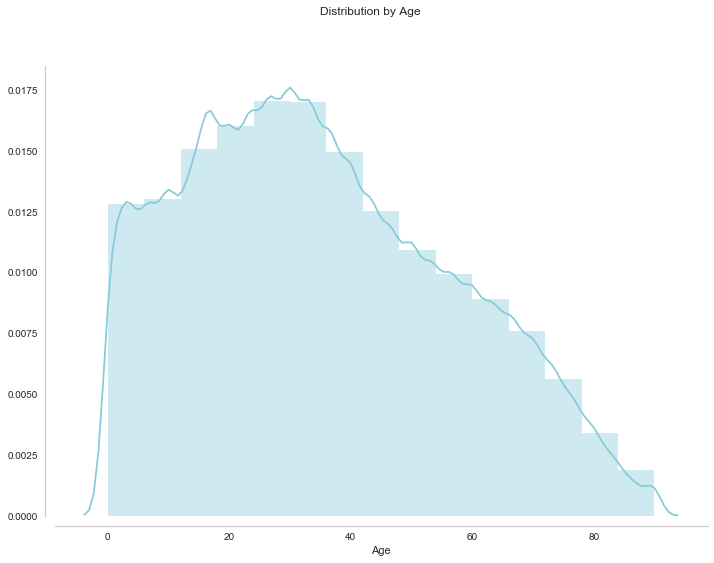

In [57]:
# Plotting data distribution  by Age
y = df.loc[:,'age']
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
age = sns.distplot(y, bins=15, color='c', ax=ax)
ax.set_xlabel('Age')
ax.grid(False)
fig.suptitle('Distribution by Age')
sns.despine(offset=10, trim=False)

 White:  1584581
 Black:  180475
 American Indian / Alaskan Native:  18859
 Asian / Pacific Islander:  43128
 Other NonWhite:  5139


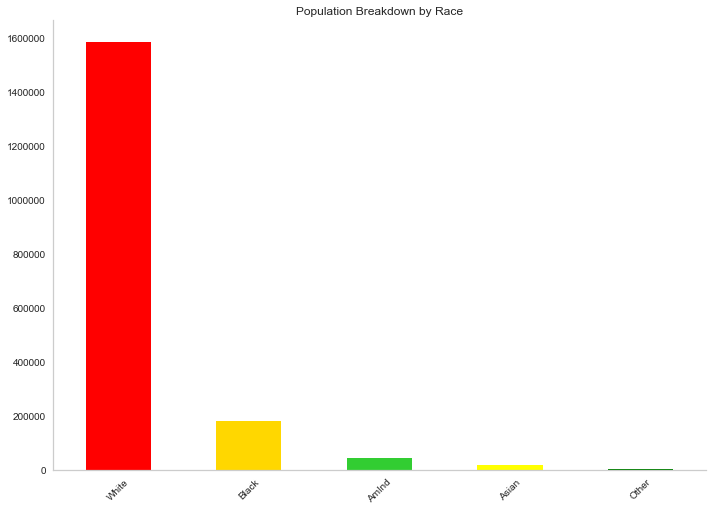

In [56]:
# Calculating population breakdown by race
Race = df.race.value_counts()
print(color.BOLD, 'White:', color.END, Race[1.0])
print(color.BOLD, 'Black:', color.END, Race[2.0])
print(color.BOLD, 'American Indian / Alaskan Native:', color.END, Race[3.0])
print(color.BOLD, 'Asian / Pacific Islander:', color.END, Race[4.0])
print(color.BOLD, 'Other NonWhite:', color.END, Race[5.0])
my_colors = ["red", "gold", "limegreen", "yellow", "green"]
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
Race.plot(kind='bar', title='Population Breakdown by Race', color=my_colors, ax=ax)
ax.set_xticklabels(['White', 'Black', 'AmInd', 'Asian', 'Other'], rotation = 45)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

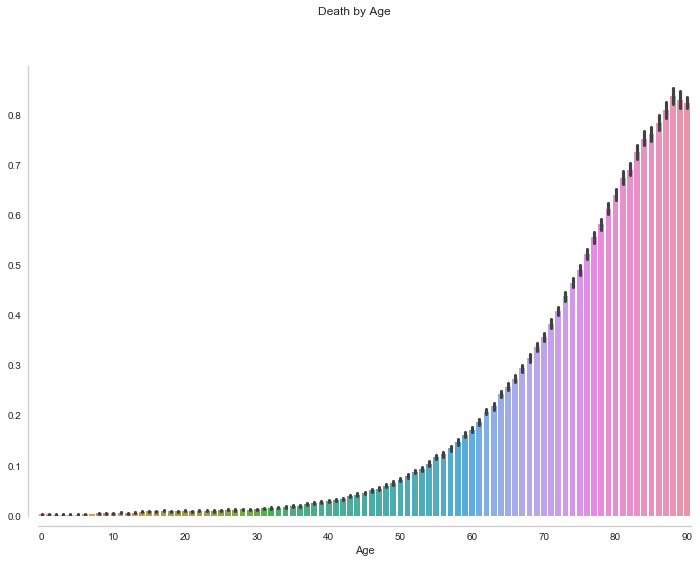

In [58]:
# Plotting death by age
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
age1 = sns.barplot(x='age', y='inddea', data=df, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('')
ax.set_xticks(np.arange(0, 91, step=10))
ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70', '80', '90'], rotation=45)
ax.grid(False)
fig.suptitle('Death by Age')
sns.despine(offset=10, trim=False)

 Survived:  1674322
 Died:  160750
 Proportion:  10.42 : 1


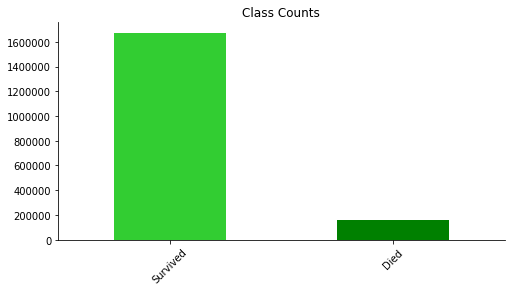

In [137]:
# Population breakdown by outcome
IndDea = dataset.inddea.value_counts()
print(color.BOLD, 'Survived:', color.END, IndDea[0])
print(color.BOLD, 'Died:', color.END, IndDea[1])
print(color.BOLD, 'Proportion:', color.END, round(IndDea[0] / IndDea[1], 2), ': 1')
my_colors = ["limegreen", "green"]
a4_dims = (8, 4)
fig, ax = plt.subplots(figsize=a4_dims)
IndDea.plot(kind='bar', title='Class Counts', color=my_colors, ax=ax)
ax.set_xticklabels(['Survived', 'Died'], rotation = 45)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

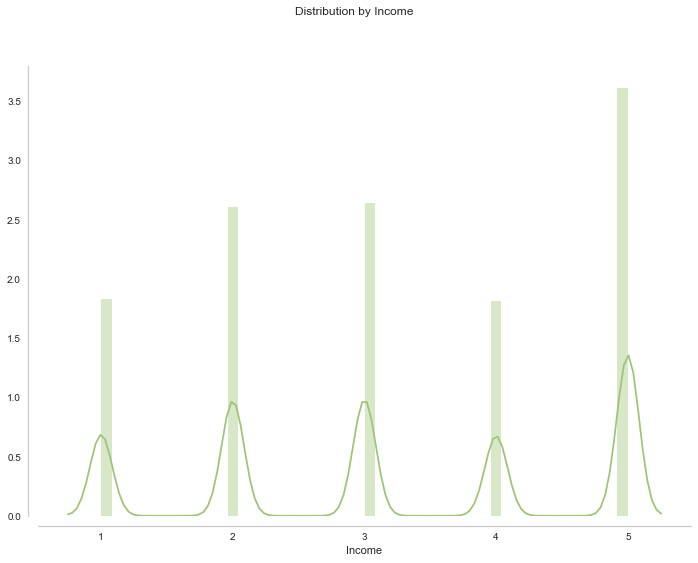

In [60]:
# Plotting data by Income
inc = df.loc[:, 'povpct']
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
age = sns.distplot(inc, color='g', ax=ax)
ax.set_xlabel('Income')
ax.grid(False)
fig.suptitle('Distribution by Income')
sns.despine(offset=10, trim=False)

[Text(0,0,'Male'), Text(0,0,'Female')]

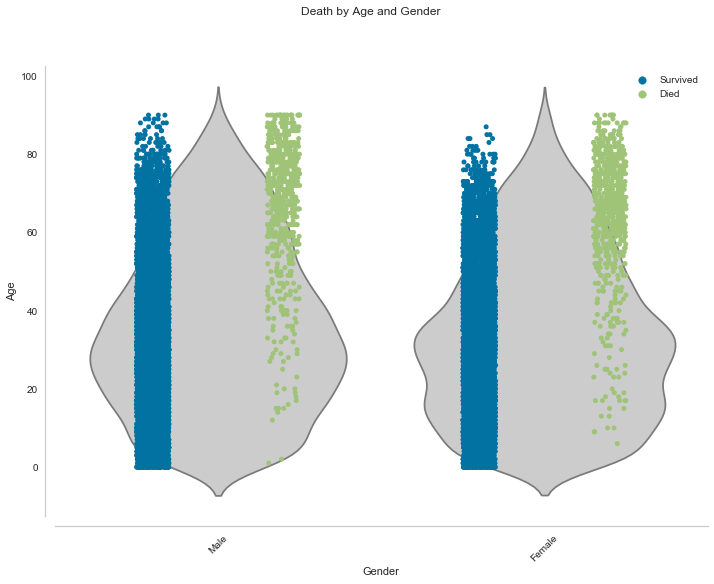

In [62]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
inc_1 = sns.violinplot(x="sex", y="age", data=df.sample(15000), inner=None, color=".8")
inc_1 = sns.stripplot(x='sex', y='age', hue='inddea', data=df.sample(15000), jitter=1, dodge=True, ax=ax)
fig.suptitle('Death by Age and Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Age')
handles, labels = ax.get_legend_handles_labels()
labels2 = ('Survived', 'Died')
ax.legend(handles, labels2)
sns.despine(offset=10, trim=False)
ax.grid(False)
ax.set_xticklabels(['Male', 'Female'], rotation=45)

[Text(0,0,'White'),
 Text(0,0,'Black'),
 Text(0,0,'AmInd'),
 Text(0,0,'Asian'),
 Text(0,0,'Other')]

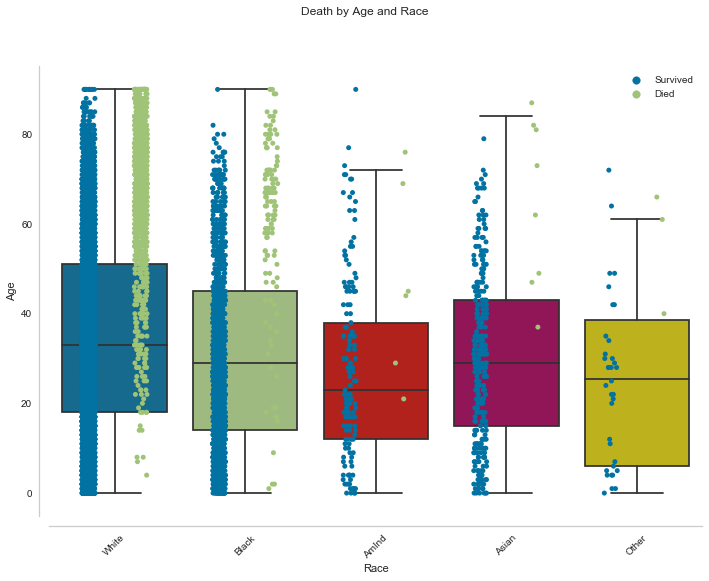

In [63]:
# Plotting data by Race and Age
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
race1 = sns.boxplot(x="race", y="age", data=df.sample(15000), whis=np.inf)
race1 = sns.stripplot(x='race', y='age', hue='inddea', data=df.sample(15000), jitter=True, dodge=True, ax=ax)
fig.suptitle('Death by Age and Race')
ax.set_xlabel('Race')
ax.set_ylabel('Age')
handles, labels = ax.get_legend_handles_labels()
labels2 = ('Survived', 'Died')
ax.legend(handles, labels2)
sns.despine(offset=10, trim=False)
ax.grid(False)
ax.set_xticklabels(['White', 'Black', 'AmInd', 'Asian', 'Other'], rotation=45)

[Text(0,0,'Urban'), Text(0,0,'Rural')]

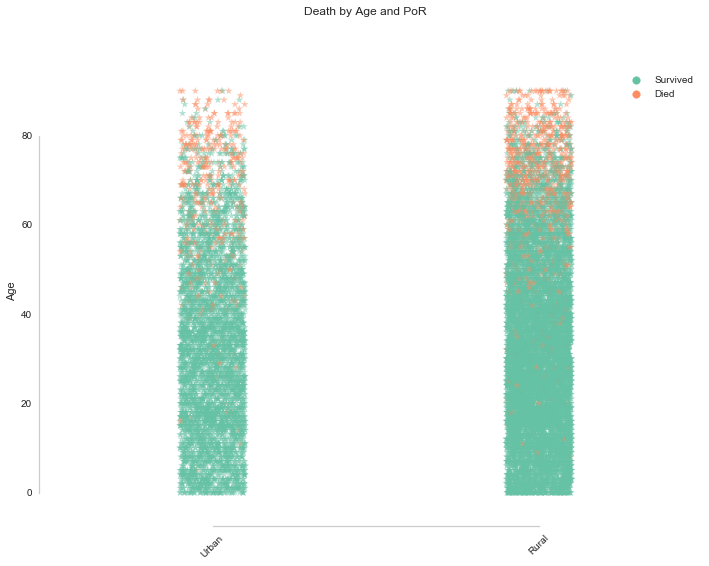

In [64]:
#Plotting data by Urban vs. Rural
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
race3 =  sns.stripplot(x="urban", y="age", hue="inddea", data=df.sample(15000), palette="Set2", size=8, marker="*", jitter=True, edgecolor="gray", alpha=.5, ax=ax)
fig.suptitle('Death by Age and PoR')
ax.set_xlabel('')
ax.set_ylabel('Age')
handles, labels = ax.get_legend_handles_labels()
labels2 = ('Survived', 'Died')
ax.legend(handles, labels2)
sns.despine(offset=10, trim=True)
ax.grid(False)
race3.set_xticklabels(["Urban", "Rural"], rotation=45)

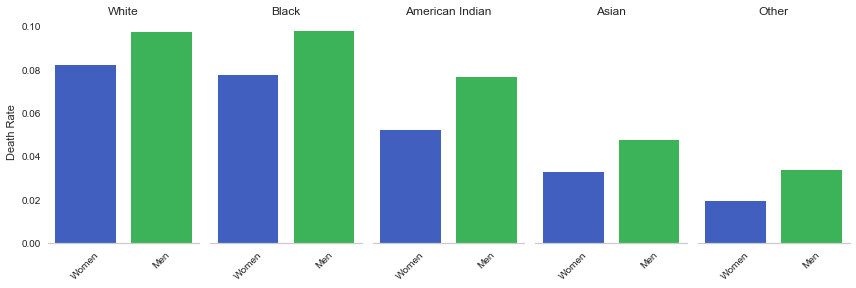

In [71]:
# Death by Race and Gender
rs = sns.factorplot(x="sex", y="inddea", col="race", data=df, saturation=.5, kind="bar", palette='bright', ci=None, aspect=.6)
(rs.set_axis_labels("", "Death Rate")
 .set_xticklabels(["Women", "Men"], rotation=45)
 .despine(left=True))
title1 = ['White']
title2 = ['Black']
title3 = ['American Indian']
title4 = ['Asian']
title5 = ['Other']
for ax, title in zip(rs.axes, title1):
    ax[0].grid(False)
    ax[0].set_title(title)
for ax, title in zip(rs.axes, title2):
    ax[1].grid(False)
    ax[1].set_title(title)
for ax, title in zip(rs.axes, title3):
    ax[2].grid(False)
    ax[2].set_title(title)
for ax, title in zip(rs.axes, title4):
    ax[3].grid(False)
    ax[3].set_title(title)
for ax, title in zip(rs.axes, title5):
    ax[4].grid(False)
    ax[4].set_title(title)

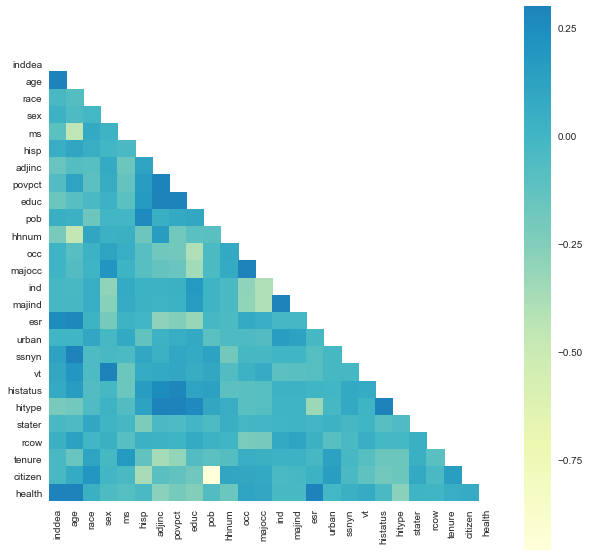

In [72]:
corr = df.loc[:, ['inddea', 'age', 'race', 'sex', 'ms', 'hisp', 'adjinc', 'povpct', 'educ', 'pob', 'hhnum', 'occ', 'majocc', 'ind', 'majind', 'esr', 'urban', 'ssnyn', 'vt', 'histatus', 'hitype', 'stater', 'rcow', 'tenure', 'citizen', 'health']].corr()
plt.figure(figsize=(10, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap='YlGnBu', center=0)
    ax.grid(False)

In [246]:
cor_dict = corr['inddea'].to_dict()
del cor_dict['inddea']
print(color.BOLD, "List of the features decendingly by their correlation with IndDea:", color.END)
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))

 List of the features decendingly by their correlation with IndDea: 
age: 0.4428533812703282
health: 0.296311178456567
esr: 0.2605435815799682
hhnum: -0.21416663983952278
hitype: -0.21401733125636838
educ: -0.15984776149698623
adjinc: -0.1490051369350987
ssnyn: 0.13280428342009526
ms: -0.0991972543922228
vt: 0.08958568437122438
histatus: 0.07583007101513946
hisp: 0.05827891337943874
povpct: -0.05753582430760992
pob: 0.0475411903450578
rcow: 0.03483234836645549
tenure: -0.02891109652950403
sex: 0.027744675858773864
race: -0.027579272972894375
citizen: -0.027459521055683507
stater: -0.026306364204457554
ind: -0.020767055886199343
majind: -0.018358976264224464
majocc: 0.013668863940373545
occ: 0.009102214177910435
urban: 0.0019339858418438527


Text(0,0.5,'Age')

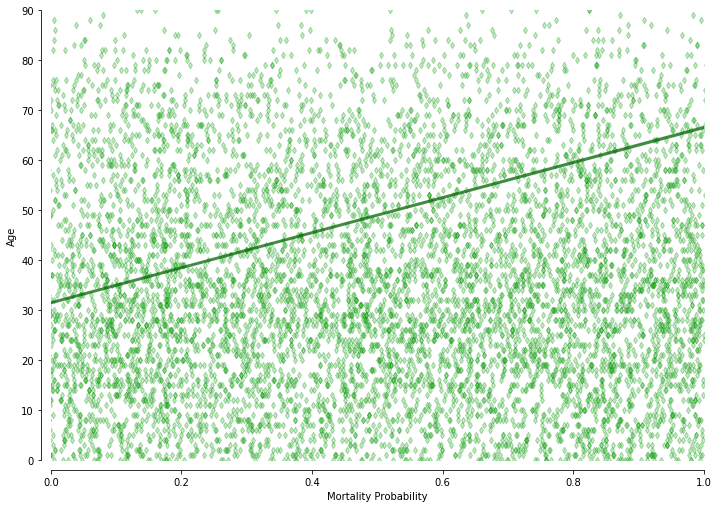

In [249]:
# Plot data and a linear regression model fit against Age variable with a 68% confidence interval, which corresponds with the standard error of the estimate:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
l = sns.regplot(x = 'inddea', y = 'age', data = df.sample(15000), ci=68, robust=True, x_jitter=1.0, marker="d", scatter_kws={"color":"limegreen", "edgecolor":"green", "alpha":0.3, "s":20}, line_kws={"color": "darkgreen", "alpha":0.7, "lw":3}, ax=ax)
l.set(xlim=(0, 1))
l.set(ylim=(0, 90))
sns.despine(offset=10, trim=True)
ax.set_xlabel('Mortality Probability')
ax.set_ylabel('Age')
ax.grid(False)

[Text(0,0,'Employed'),
 Text(0,0,'Abs. from Work'),
 Text(0,0,'Unemployed'),
 Text(0,0,'Disabled'),
 Text(0,0,'Other')]

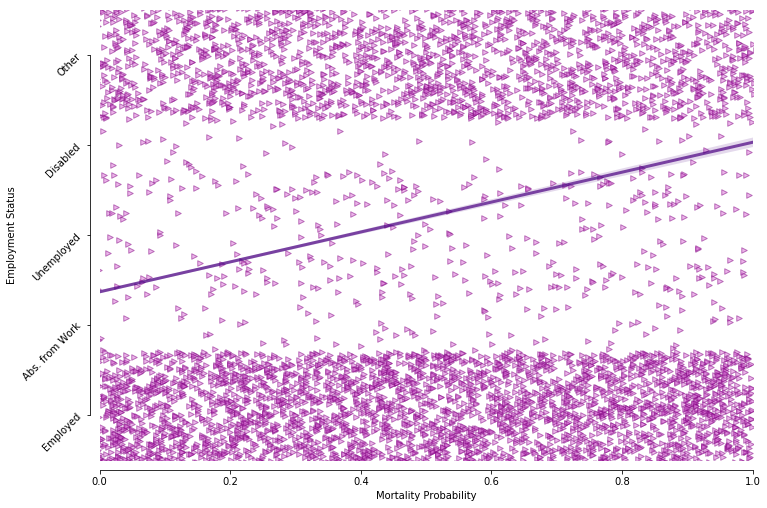

In [250]:
# Plot data and a linear regression model fit against Employment variable
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
l = sns.regplot(x = 'inddea', y = 'esr', data = df.sample(15000), ci=68, robust=True, y_jitter=0.7, x_jitter=1.0, marker=">", scatter_kws={"color": "orchid", "edgecolor":"purple", "alpha":0.5, "s":30}, line_kws={"color": "indigo", "alpha":0.7, "lw":3}, ax=ax)
l.set(xlim=(0, 1))
l.set(ylim=(0.5, 5.5))
sns.despine(offset=10, trim=True)
ax.set_xlabel('Mortality Probability')
ax.set_ylabel('Employment Status')
ax.set_yticklabels(["Employed", "Abs. from Work", "Unemployed", "Disabled", "Other"], rotation=45)
ax.grid(False)

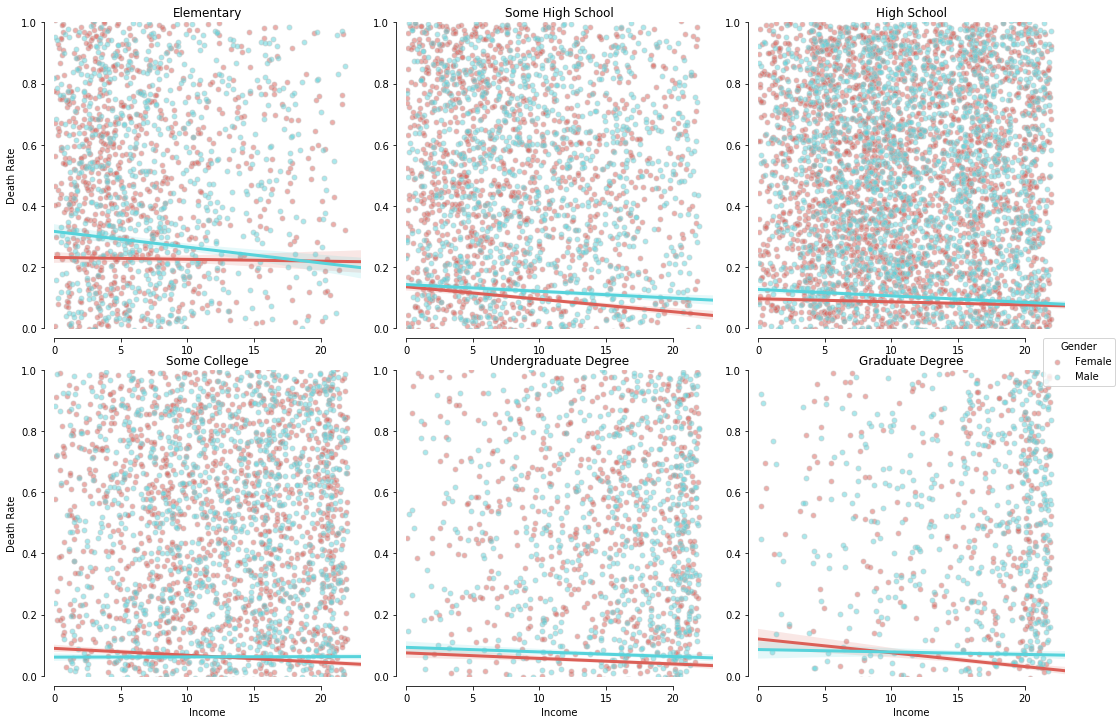

In [328]:
# Plotting Inddea against Education, Income and Gender
df1 = (df.loc[df['educ'].isin([2,5,8,9,12,13])])
g = sns.lmplot(x="povpct", y="inddea",ci=68, data=df1.sample(25000), col="educ", hue="sex", size=5, legend_out=True, palette="hls", col_wrap=3, scatter_kws={"s": 25, "edgecolor":"silver", "alpha":.5}, line_kws={"lw":3, "alpha":1.0}, x_jitter=1.0, y_jitter=1.0, sharex=False, sharey=False)
(g.set_axis_labels("Income", "Death Rate")
 #.set_xticklabels(["Women", "Men"], rotation=45)
 .despine(left=True))
fig = g.fig
a0 = fig.axes[0]
a0.set_title("Elementary")
a1 = fig.axes[1]
a1.set_title("Some High School")
a2 = fig.axes[2]
a2.set_title("High School")
a3 = fig.axes[3]
a3.set_title("Some College")
a4 = fig.axes[4]
a4.set_title("Undergraduate Degree")
a5 = fig.axes[5]
a5.set_title("Graduate Degree")
g.set(xlim=(0, 23))
g.set(ylim=(0, 1))
sns.despine(offset=10, trim=True)
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g._legend.set_title('Gender')

In [323]:
# Creating Kaplan-Meier estimates
# Creating Duration array and Outcome array to fit the model
D = dataset["follow"]
O = dataset["inddea"]

Text(0.5,1,'Survival of observed population')

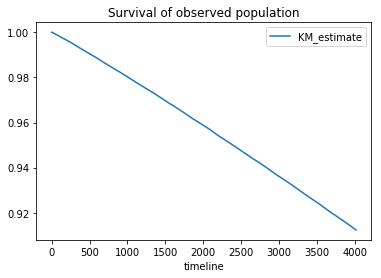

In [325]:
# Creating KMF model
kmf = KaplanMeierFitter()
kmf.fit(D, event_observed=O)
kmf.survival_function_.plot()
plt.title('Survival of observed population')

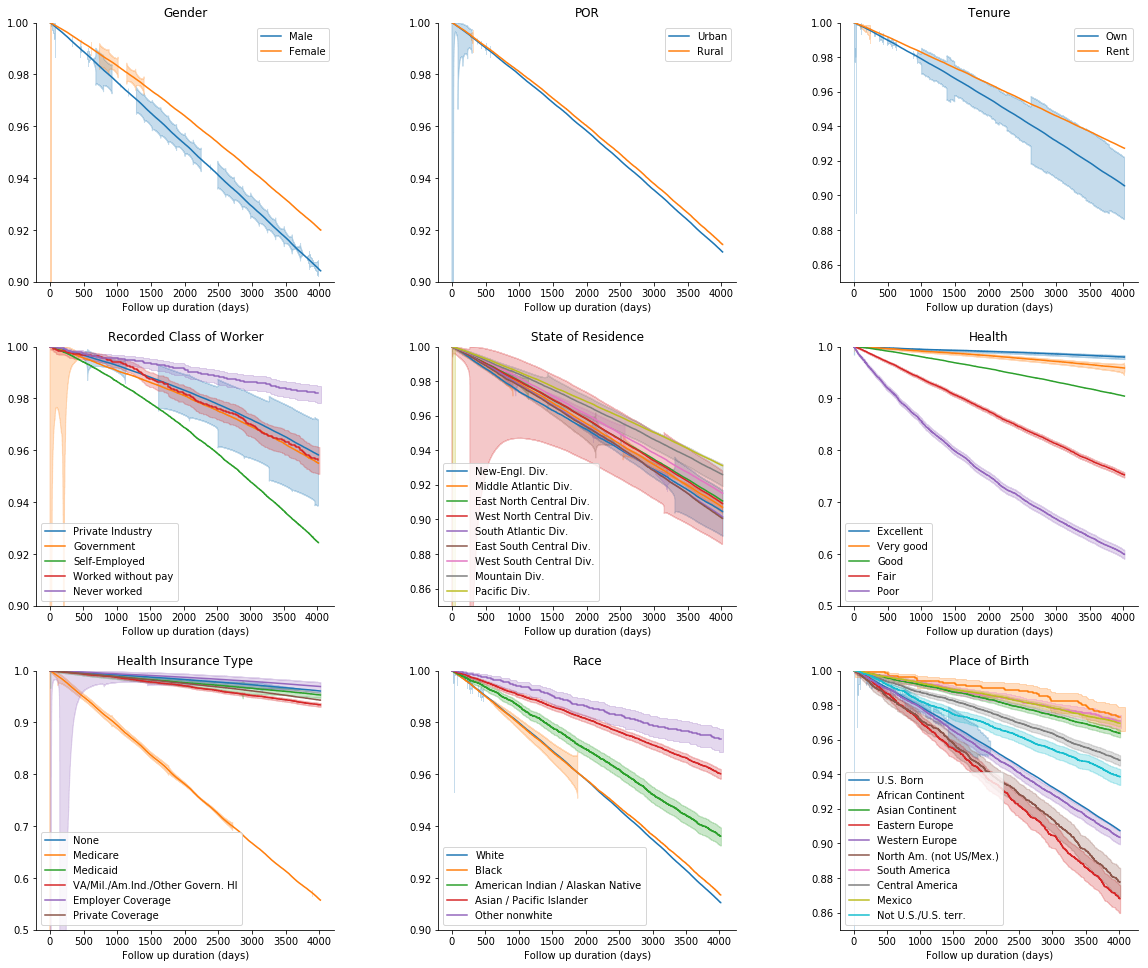

In [329]:
# Arranging all plots together to facilitate visual comparison
# Plotting survival probability by Gender
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(331)
sex = (dataset["sex"] == 1)
kmf.fit(D[sex], event_observed=O[sex], label="Male")
kmf.plot(ax=ax, ci_force_lines=False)
kmf.fit(D[~sex], event_observed=O[~sex], label="Female")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1);
plt.title("Gender")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by Urban vs Rural POR
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(332)
POR = (dataset["urban"] == 1)
kmf.fit(D[POR], event_observed=O[POR], label="Urban")
kmf.plot(ax=ax, ci_force_lines=False)
kmf.fit(D[~POR], event_observed=O[~POR], label="Rural")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1);
plt.title("POR")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by Tenure
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(333)
ten = (dataset["tenure"] == 1)
kmf.fit(D[ten], event_observed=O[ten], label="Own")
kmf.plot(ax=ax, ci_force_lines=False)
kmf.fit(D[~ten], event_observed=O[~ten], label="Rent")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.85, 1);
plt.title("Tenure")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by RCOW
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(334)
rcow = (dataset["rcow"] == 1)
kmf.fit(D[rcow], event_observed=O[rcow], label="Private Industry")
kmf.plot(ax=ax, ci_force_lines=False)
rcow2 = (dataset["rcow"] == 2)
kmf.fit(D[rcow2], event_observed=O[rcow2], label="Government")
kmf.plot(ax=ax, ci_force_lines=False)
rcow3 = (dataset["rcow"] == 3)
kmf.fit(D[rcow3], event_observed=O[rcow3], label="Self-Employed")
kmf.plot(ax=ax, ci_force_lines=False)
rcow4 = (dataset["rcow"] == 4)
kmf.fit(D[rcow4], event_observed=O[rcow4], label="Worked without pay")
kmf.plot(ax=ax, ci_force_lines=False)
rcow5 = (dataset["rcow"] == 5)
kmf.fit(D[rcow5], event_observed=O[rcow5], label="Never worked")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1);
plt.title("Recorded Class of Worker")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by StateR
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(335)
ned=[11,12,13,14,15,16]
mad=[21,22,23]
encd=[31,32,33,34,35]
wncd=[41,42,43,44,45,46,47]
sad=[51,52,53,54,55,56,57,58,59]
escd=[61,62,63,64]
wscd=[71,72,73,74]
md=[81,82,83,84,85,86,87,88]
pd=[91,92,93,94,95]
state1 = (dataset["stater"].isin (ned))
kmf.fit(D[state1], event_observed=O[state1], label="New-Engl. Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state2 = (dataset["stater"].isin (mad))
kmf.fit(D[state2], event_observed=O[state2], label="Middle Atlantic Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state3 = (dataset["stater"].isin (encd))
kmf.fit(D[state3], event_observed=O[state3], label="East North Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state4 = (dataset["stater"].isin (wncd))
kmf.fit(D[state4], event_observed=O[state4], label="West North Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state5 = (dataset["stater"].isin (sad))
kmf.fit(D[state5], event_observed=O[state5], label="South Atlantic Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state6 = (dataset["stater"].isin (escd))
kmf.fit(D[state6], event_observed=O[state6], label="East South Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state7 = (dataset["stater"].isin (wscd))
kmf.fit(D[state7], event_observed=O[state7], label="West South Central Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state8 = (dataset["stater"].isin (md))
kmf.fit(D[state8], event_observed=O[state8], label="Mountain Div.")
kmf.plot(ax=ax, ci_force_lines=False)
state9 = (dataset["stater"].isin (pd))
kmf.fit(D[state9], event_observed=O[state9], label="Pacific Div.")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.85, 1);
plt.title("State of Residence")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by Health
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(336)
health1 = (dataset["health"]==1)
kmf.fit(D[health1], event_observed=O[health1], label="Excellent")
kmf.plot(ax=ax, ci_force_lines=False)
health2 = (dataset["health"]==2)
kmf.fit(D[health2], event_observed=O[health2], label="Very good")
kmf.plot(ax=ax, ci_force_lines=False)
health3 = (dataset["health"]==3)
kmf.fit(D[health3], event_observed=O[health3], label="Good")
kmf.plot(ax=ax, ci_force_lines=False)
health4 = (dataset["health"]==4)
kmf.fit(D[health4], event_observed=O[health4], label="Fair")
kmf.plot(ax=ax, ci_force_lines=False)
health5 = (dataset["health"]==5)
kmf.fit(D[health5], event_observed=O[health5], label="Poor")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.5, 1);
plt.title("Health")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by Health Insurance Type
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(337)
hitype = (dataset["hitype"]==0)
kmf.fit(D[hitype], event_observed=O[hitype], label="None")
kmf.plot(ax=ax, ci_force_lines=False)
hitype1 = (dataset["hitype"]==1)
kmf.fit(D[hitype1], event_observed=O[hitype1], label="Medicare")
kmf.plot(ax=ax, ci_force_lines=False)
hitype2 = (dataset["hitype"]==2)
kmf.fit(D[hitype2], event_observed=O[hitype2], label="Medicaid")
kmf.plot(ax=ax, ci_force_lines=False)
hitype3 = (dataset["hitype"]==3)
kmf.fit(D[hitype3], event_observed=O[hitype3], label="VA/Mil./Am.Ind./Other Govern. HI")
kmf.plot(ax=ax, ci_force_lines=False)
hitype4 = (dataset["hitype"]==4)
kmf.fit(D[hitype4], event_observed=O[hitype4], label="Employer Coverage")
kmf.plot(ax=ax, ci_force_lines=False)
hitype5 = (dataset["hitype"]==5)
kmf.fit(D[hitype5], event_observed=O[hitype5], label="Private Coverage")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.5, 1);
plt.title("Health Insurance Type")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by Race
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(338)
race1 = (dataset["race"]==1)
kmf.fit(D[race1], event_observed=O[race1], label="White")
kmf.plot(ax=ax, ci_force_lines=False)
race2 = (dataset["race"]==2)
kmf.fit(D[race2], event_observed=O[race2], label="Black")
kmf.plot(ax=ax, ci_force_lines=False)
race3 = (dataset["race"]==3)
kmf.fit(D[race3], event_observed=O[race3], label="American Indian / Alaskan Native")
kmf.plot(ax=ax, ci_force_lines=False)
race4 = (dataset["race"]==4)
kmf.fit(D[race4], event_observed=O[race4], label="Asian / Pacific Islander")
kmf.plot(ax=ax, ci_force_lines=False)
race5 = (dataset["race"]==5)
kmf.fit(D[race5], event_observed=O[race5], label="Other nonwhite")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.9, 1)
plt.title("Race")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Plotting survival probability by POB
fig = plt.gcf()
fig.set_size_inches(18,15)
ax = plt.subplot(339)
us=[901,902,904,905, 906, 908, 909,910,911,912,913,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,944,945,946,947,948,949,950,951,953,954,955,956,957,958, 959,960]
pob1 = (dataset["pob"].isin(us))
kmf.fit(D[pob1], event_observed=O[pob1], label="U.S. Born")
kmf.plot(ax=ax, ci_force_lines=False)
pob2 = (dataset["pob"]==101)
kmf.fit(D[pob2], event_observed=O[pob2], label="African Continent")
kmf.plot(ax=ax, ci_force_lines=False)
pob3 = (dataset["pob"]==102)
kmf.fit(D[pob3], event_observed=O[pob3], label="Asian Continent")
kmf.plot(ax=ax, ci_force_lines=False)
pob4 = (dataset["pob"]==103)
kmf.fit(D[pob4], event_observed=O[pob4], label="Eastern Europe")
kmf.plot(ax=ax, ci_force_lines=False)
pob5 = (dataset["pob"]==104)
kmf.fit(D[pob5], event_observed=O[pob5], label="Western Europe")
kmf.plot(ax=ax, ci_force_lines=False)
pob6 = (dataset["pob"]==105)
kmf.fit(D[pob6], event_observed=O[pob6], label="North Am. (not US/Mex.)")
kmf.plot(ax=ax, ci_force_lines=False)
pob7 = (dataset["pob"]==106)
kmf.fit(D[pob7], event_observed=O[pob7], label="South America")
kmf.plot(ax=ax, ci_force_lines=False)
pob8 = (dataset["pob"]==107)
kmf.fit(D[pob8], event_observed=O[pob8], label="Central America")
kmf.plot(ax=ax, ci_force_lines=False)
pob9 = (dataset["pob"]==108)
kmf.fit(D[pob9], event_observed=O[pob9], label="Mexico")
kmf.plot(ax=ax, ci_force_lines=False)
pob10 = (dataset["pob"]==111)
kmf.fit(D[pob10], event_observed=O[pob10], label="Not U.S./U.S. terr.")
kmf.plot(ax=ax, ci_force_lines=False)
plt.ylim(0.85, 1)
plt.title("Place of Birth")
plt.xlabel("Follow up duration (days)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

In [364]:
# Doing the same in pyplot for 11 dataset
# Plotting survival probability by Health Insurance Type
fig = plt.gcf()
#fig.set_size_inches(18,15)
ax = plt.subplot(331)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
hitype = (dataset["hitype"]==0)
kmf.fit(D[hitype], event_observed=O[hitype], label="None")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype1 = (dataset["hitype"]==1)
kmf.fit(D[hitype1], event_observed=O[hitype1], label="Medicare")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype2 = (dataset["hitype"]==2)
kmf.fit(D[hitype2], event_observed=O[hitype2], label="Medicaid")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype3 = (dataset["hitype"]==3)
kmf.fit(D[hitype3], event_observed=O[hitype3], label="VA/Mil./Am.Ind./Other Govern. HI")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype4 = (dataset["hitype"]==4)
kmf.fit(D[hitype4], event_observed=O[hitype4], label="Employer Coverage")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
hitype5 = (dataset["hitype"]==5)
kmf.fit(D[hitype5], event_observed=O[hitype5], label="Private Coverage")
kmf.plot(ax=ax, ci_force_lines=True, legend=False)
plt.ylim(0.5, 1);
#plt.title("Health Insurance Type")
plt.xlabel("Follow up duration (days)")

tls.set_credentials_file(username='yg7891', api_key='cjs1S61VN1STTLYXnhz7')
b = plt.gcf()

def pyplot(b, ci=False, legend=True, filename='HealthInsurance_Interactive'):
    # Convert mpl fig obj to plotly fig obj, resize to plotly's default
    py_fig = tls.mpl_to_plotly(b, resize=True)
   
    if legend == True:
        # Add legend, place it at the top right corner of the plot
        py_fig['layout'].update(
            showlegend=True,
            title='Health Insurance',
            titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='black'),
            width=900,
            height=600,
            legend=layout.Legend(
                x=1.01,
                y=1
            )
        )
        
    # Send updated figure object to Plotly, show result in notebook
    return py.iplot(py_fig, filename=filename)
                   
pyplot(b)

The draw time for this plot will be slow for clients without much RAM.


In [9]:
df.columns

Index(['record', 'age', 'race', 'sex', 'ms', 'hisp', 'adjinc', 'educ', 'pob',
       'wt', 'hhid', 'hhnum', 'reltrf', 'occ', 'majocc', 'ind', 'majind',
       'esr', 'urban', 'smsast', 'inddea', 'cause113', 'follow', 'dayod',
       'hosp', 'hospd', 'ssnyn', 'vt', 'histatus', 'hitype', 'povpct',
       'stater', 'rcow', 'tenure', 'citizen', 'health', 'indalg'],
      dtype='object')

In [6]:
# Dropping some variables from the dataset based on missing data, bias and low correlation with IndDea
df = df.drop(['record', 'race', 'hisp', 'adjinc', 'wt', 'hhid', 'hhnum', 'reltrf', 'occ', 'ind', 'majind', 'smsast', 'majocc', 'cause113', 'follow', 'dayod', 'hosp', 'hospd', 'rcow', 'tenure', 'citizen', 'health', 'indalg'], axis=1)
df.columns

Index(['age', 'sex', 'ms', 'educ', 'pob', 'esr', 'urban', 'inddea', 'ssnyn',
       'vt', 'histatus', 'hitype', 'povpct', 'stater'],
      dtype='object')

In [7]:
# Dropping rows with missing values
df.dropna(axis=0, how='any', inplace=True)

In [8]:
# Casting data type as int instead of float
df.ms = df.ms.astype(int)
df.educ = df.educ.astype(int)
df.esr = df.esr.astype(int)
df.urban = df.urban.astype(int)
df.vt = df.vt.astype(int)
df.histatus = df.histatus.astype(int)
df.hitype = df.hitype.astype(int)

In [10]:
df.head()

,age,sex,ms,educ,pob,esr,urban,inddea,ssnyn,vt,histatus,hitype,povpct,stater
577765,61,1,1,2,900,5,1,0,1,1,0,0,4,1
577766,63,0,1,5,900,5,1,0,1,0,0,0,4,1
577767,67,0,2,2,900,5,1,0,1,0,1,1,2,1
577768,55,1,1,5,900,1,1,0,1,1,1,4,5,1
577769,52,0,1,8,900,1,1,0,1,0,1,4,5,1


In [9]:
df = df.drop(['povpct', 'stater'], axis=1)

In [10]:
X = df.drop(['inddea'], axis=1)
y = df.loc[:, 'inddea']

In [13]:
X.head()

,age,sex,ms,educ,pob,esr,urban,ssnyn,vt,histatus,hitype
577765,61,1,1,2,900,5,1,1,1,0,0
577766,63,0,1,5,900,5,1,1,0,0,0
577767,67,0,2,2,900,5,1,1,0,1,1
577768,55,1,1,5,900,1,1,1,1,1,4
577769,52,0,1,8,900,1,1,1,0,1,4


In [11]:
# Encoding some features
X = pd.get_dummies(data=X, columns=['ms', 'educ', 'pob', 'esr', 'hitype'])

In [12]:
X.head()
cols = (X.columns)
print(cols)
X.shape

Index(['age', 'sex', 'urban', 'ssnyn', 'vt', 'histatus', 'ms_1', 'ms_2',
       'ms_3', 'ms_4', 'ms_5', 'educ_1', 'educ_2', 'educ_5', 'educ_8',
       'educ_9', 'educ_12', 'educ_13', 'pob_0', 'pob_101', 'pob_102',
       'pob_103', 'pob_104', 'pob_105', 'pob_106', 'pob_107', 'pob_108',
       'pob_110', 'pob_900', 'esr_1', 'esr_2', 'esr_3', 'esr_4', 'esr_5',
       'hitype_0', 'hitype_1', 'hitype_2', 'hitype_3', 'hitype_4', 'hitype_5'],
      dtype='object')


(1012172, 40)

In [13]:
# Splitting the dataset into the Training set and Test set prior to fitting / resampling
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = 0)

In [33]:
# Identify statistically significant variables
regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
print(regressor_OLS.summary())
y_pred_ols = regressor_OLS.predict(X_test)
print('Predicted values: ', regressor_OLS.predict())

                            OLS Regression Results                            
Dep. Variable:                 inddea   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     9619.
Date:                Sat, 25 Aug 2018   Prob (F-statistic):               0.00
Time:                        09:40:17   Log-Likelihood:                -64137.
No. Observations:              809737   AIC:                         1.283e+05
Df Residuals:                  809701   BIC:                         1.288e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0055    2.8e-05    196.052      0.0

In [35]:
# Ridge
model = Ridge(alpha=0.0001)
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

model = Ridge(alpha=0.0001)
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

[('age', 0.005499868896978931), ('sex', 0.04649382714464449), ('urban', 0.00829552490939139), ('ssnyn', 0.07155988494883961), ('vt', 0.004516406052101675), ('histatus', -0.015848159777941687), ('ms_1', -0.034730331873771315), ('ms_2', 0.043180231293079865), ('ms_3', -0.017871031585993926), ('ms_4', -0.010025439250058386), ('ms_5', 0.019344899821425374), ('educ_1', -0.004377234068384017), ('educ_2', 0.04081639259372005), ('educ_5', 0.021083272959117917), ('educ_8', -0.0027656454563116267), ('educ_9', -0.006147198613072458), ('educ_12', -0.01640452752371393), ('educ_13', -0.03234083014173098), ('pob_0', 0.01567016862822053), ('pob_101', 0.007126953383053153), ('pob_102', 0.0006735266493591326), ('pob_103', -0.0033692279516887875), ('pob_104', -0.0013229866618032023), ('pob_105', 0.005903845004820834), ('pob_106', -0.007115117812864455), ('pob_107', -0.012773702786522432), ('pob_108', -0.008531337353265143), ('pob_110', -0.023356519546522292), ('pob_900', 0.02704407825690962), ('esr_1', -

In [38]:
# Lasso
model = Lasso(alpha=0.0001)
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

model = Lasso(alpha=0.0001)
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

[('age', 0.005520162535850659), ('sex', 0.046093328913192115), ('urban', 0.007390765251089485), ('ssnyn', 0.0709918664629631), ('vt', 0.0038168078042835163), ('histatus', 0.0), ('ms_1', -0.02486373283690371), ('ms_2', 0.05167316452178046), ('ms_3', -0.006763108616920163), ('ms_4', -0.0), ('ms_5', 0.029043377836980393), ('educ_1', 0.0), ('educ_2', 0.04407572342409484), ('educ_5', 0.025445025320677297), ('educ_8', 0.0018843153383437576), ('educ_9', -0.0006625633529665435), ('educ_12', -0.010449472938197766), ('educ_13', -0.025702061648912387), ('pob_0', 0.015083453728531161), ('pob_101', 0.0), ('pob_102', 0.0), ('pob_103', -0.0), ('pob_104', 0.0), ('pob_105', 0.0), ('pob_106', -0.0), ('pob_107', -0.003958744568895005), ('pob_108', -0.0010701777104137385), ('pob_110', -0.008607031247124355), ('pob_900', 0.02958970061661552), ('esr_1', -0.015751800439738173), ('esr_2', -0.000600603585949134), ('esr_3', -0.0), ('esr_4', 0.11305878290595799), ('esr_5', 0.029448092718665324), ('hitype_0', -0.

In [39]:
# Elastic Net
model = ElasticNet(l1_ratio = 0.002)
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

model = ElasticNet(l1_ratio = 0.002)
sfm = SelectFromModel(model)
sfm.fit(X, y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

[('age', 0.007733053017226338), ('sex', 0.005763803587109111), ('urban', 0.0), ('ssnyn', 0.009036184121510206), ('vt', 0.0), ('histatus', 0.0), ('ms_1', -0.011239682855891215), ('ms_2', 0.0033839330039059485), ('ms_3', -0.0), ('ms_4', -0.0), ('ms_5', 0.0077864425677308035), ('educ_1', 0.0), ('educ_2', 0.0031875559485657896), ('educ_5', 0.003924256598141938), ('educ_8', -0.0007694016407084332), ('educ_9', -4.8475024183828896e-05), ('educ_12', -0.001211625716711397), ('educ_13', -0.001211384483011973), ('pob_0', -0.0), ('pob_101', -0.0), ('pob_102', -0.0), ('pob_103', -0.0), ('pob_104', -0.0), ('pob_105', -0.0), ('pob_106', -0.0), ('pob_107', -0.0), ('pob_108', -0.0), ('pob_110', -0.0), ('pob_900', 0.0020570334539747786), ('esr_1', -0.011288798648845844), ('esr_2', -0.0), ('esr_3', 0.0), ('esr_4', 0.0013578300703882007), ('esr_5', 0.008166900104889562), ('hitype_0', -0.0), ('hitype_1', 0.011987140243124427), ('hitype_2', 0.0), ('hitype_3', 0.0), ('hitype_4', -0.010442106201552786), ('hit

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.svm import LinearSVC

model = Pipeline([
    ('std', StandardScaler()),
    ('select', SelectKBest(k=10)),
    ('model', LinearSVC()),  
])

model.fit(X, y)

sfm = model.named_steps['select']
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['age', 'vt', 'ms_2', 'ms_5', 'educ_2', 'esr_1', 'esr_4', 'esr_5', 'hitype_1', 'hitype_4']


  Train Time: 11.224s 
[[149175  31385]
 [  3879  17996]]


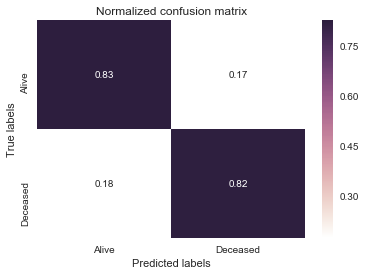

In [14]:
# Logistic Regression with balanced classes
logreg = LogisticRegression(C=1, class_weight='balanced')
t0 = time()
lr = logreg.fit(X_train, y_train)
train_time_lr = time() - t0
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_lr, color.END)
y_pred_lr = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)

 Sensitivity_Specificity_Support:   (0.8258008743547312, 0.8230530746293817, None)
 Recall Score:   0.8226742857142857
 Precision Score:   0.9087155417270854
 Accuracy Score:   0.8258008743547312
 F1 Score:   0.852241517738176


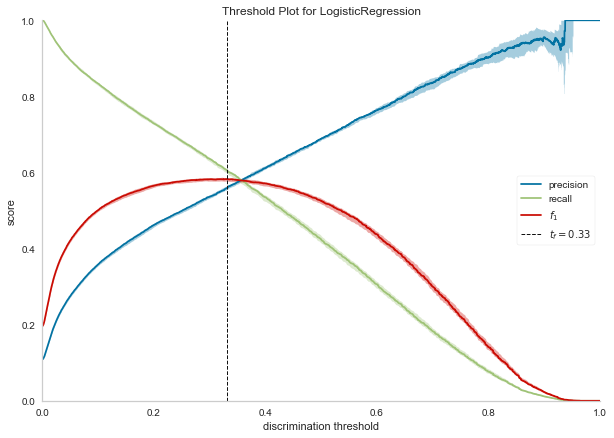

In [74]:
print(color.BOLD, 'Sensitivity_Specificity_Support: ', color.END, sensitivity_specificity_support(y_test, y_pred_lr, average='weighted')) #Sensitivity (ratio TP / (TP + FN) - quantifies the ability to avoid false negatives)
print(color.BOLD, 'Recall Score: ', color.END, recall_score(y_test, y_pred_lr)) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, precision_score(y_test, y_pred_lr, average='weighted'))
print(color.BOLD, 'Accuracy Score: ', color.END, accuracy_score(y_test, y_pred_lr))
print(color.BOLD, 'F1 Score: ', color.END, f1_score(y_test, y_pred_lr, average='weighted'))

# Instantiate the classification model and visualizer
figsize=(10, 7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(logreg, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data

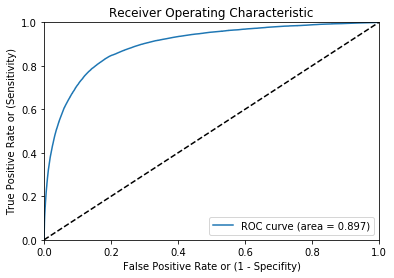

In [42]:
# Plotting ROC curve for logistic regression model
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba[:5]
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plot_roc_curve(y_test, y_pred_proba)

  Train Time: 11.248s 
[[156745  23815]
 [  5735  16140]]


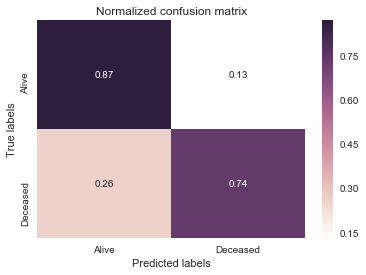

In [21]:
# Random Forest Classifier with balanced classes
n_estimator = 25
clf_rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, random_state=12, class_weight='balanced')
t0 = time()
clf_rf.fit(X_train, y_train)
train_time_rf = time() - t0
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_rf, color.END)
y_pred_rf = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)

 Sensitivity_Specificity_Support:   (0.854027218613382, 0.7519061379281712, None)
 Recall Score:   0.7378285714285714
 Precision Score:   0.9041091713401317
 Accuracy Score:   0.854027218613382
 F1 Score:   0.8715227470267479


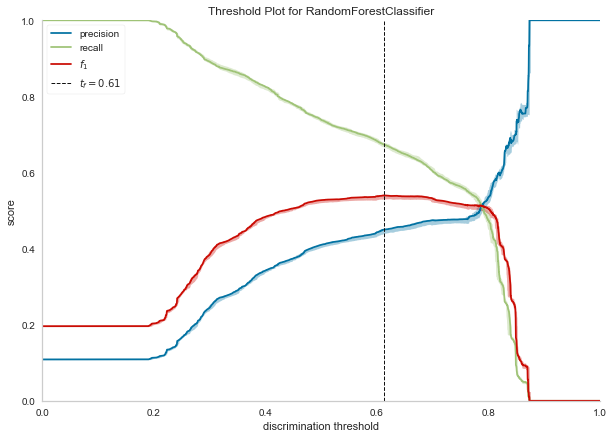

In [77]:
print(color.BOLD, 'Sensitivity_Specificity_Support: ', color.END, sensitivity_specificity_support(y_test, y_pred_rf, average='weighted')) #Sensitivity (ratio TP / (TP + FN) - quantifies the ability to avoid false negatives)
print(color.BOLD, 'Recall Score: ', color.END, recall_score(y_test, y_pred_rf)) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, precision_score(y_test, y_pred_rf, average='weighted'))
print(color.BOLD, 'Accuracy Score: ', color.END, accuracy_score(y_test, y_pred_rf))
print(color.BOLD, 'F1 Score: ', color.END, f1_score(y_test, y_pred_rf, average='weighted'))

# Instantiate the classification model and visualizer
figsize=(10, 7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(clf_rf, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data

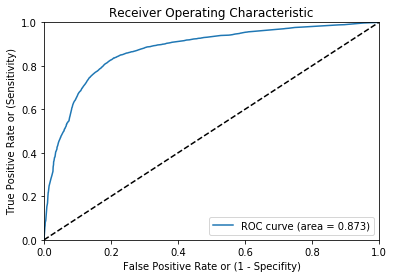

In [45]:
# Plotting ROC curve for random forest classifier model
y_pred_proba_rf = clf_rf.predict_proba(X_test)
y_pred_proba_rf[:5]
def plot_roc_curve(y_test, y_pred_proba_rf):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plot_roc_curve(y_test, y_pred_proba_rf)

  Train Time: 34.337s 
[[145276  35284]
 [  5758  16117]]


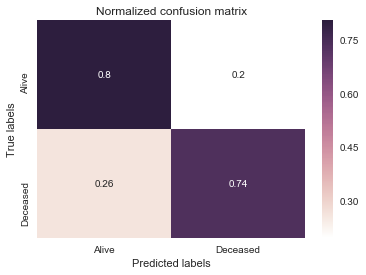

In [26]:
# Unsupervised transformation based on totally random trees
n_estimator = 10
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator, random_state=0)
rt_lm = LogisticRegression(class_weight='balanced')
pipeline = make_pipeline(rt, rt_lm)
t0 = time()
pipeline.fit(X_train, y_train)
train_time_rt = time() - t0
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_rt, color.END)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
y_pred_rt_1 = np.around(y_pred_rt)
cm = confusion_matrix(y_test, y_pred_rt_1)
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)

 Sensitivity_Specificity_Support:   (0.7972583792328402, 0.7441044968985605, None)
 Recall Score:   0.7367771428571429
 Precision Score:   0.8918188707183295
 Accuracy Score:   0.7972583792328402
 F1 Score:   0.8290786437609781


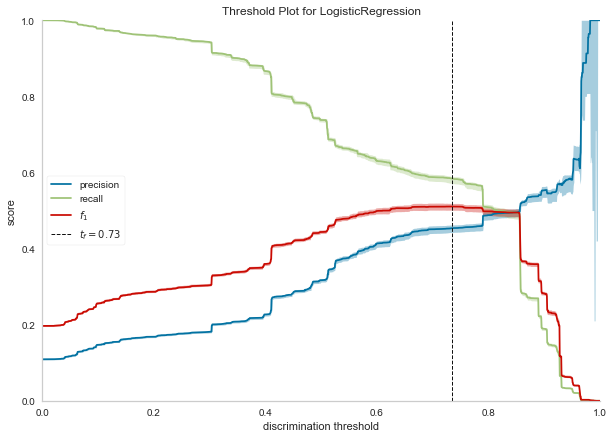

In [78]:
print(color.BOLD, 'Sensitivity_Specificity_Support: ', color.END, sensitivity_specificity_support(y_test, y_pred_rt_1, average='weighted')) #Sensitivity (ratio TP / (TP + FN) - quantifies the ability to avoid false negatives)
print(color.BOLD, 'Recall Score: ', color.END, recall_score(y_test, y_pred_rt_1)) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, precision_score(y_test, y_pred_rt_1, average='weighted'))
print(color.BOLD, 'Accuracy Score: ', color.END, accuracy_score(y_test, y_pred_rt_1))
print(color.BOLD, 'F1 Score: ', color.END, f1_score(y_test, y_pred_rt_1, average='weighted'))

# Instantiate the classification model and visualizer
figsize=(10, 7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(pipeline, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data

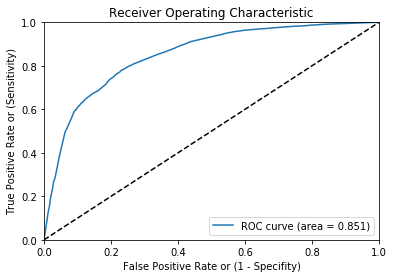

In [47]:
# Plotting ROC curve for random trees + logistic regression model
y_pred_rt[:5]
def plot_roc_curve(y_test, y_pred_rt):
    #fpr, tpr, thresholds = roc_curve(y_test, y_pred_rt[:, 1])
    roc_auc = auc(fpr_rt_lm, tpr_rt_lm)
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plot_roc_curve(y_test, y_pred_rt)

Original dataset shape Counter({0: 721470, 1: 88267})
Resampled dataset shape Counter({0: 721457, 1: 721457})
  Train Time: 2114.378s 
[[149481  31079]
 [  3937  17938]]


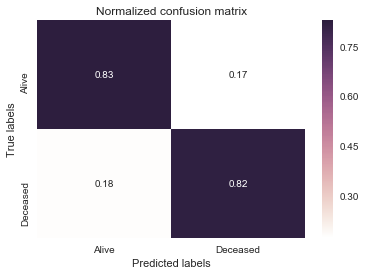

In [28]:
# Resampling Data Set: SMOTETomek (Over + Under Sampling) + Logistic Regression
print('Original dataset shape {}'.format(Counter(y_train)))
smt = SMOTETomek(ratio='auto')
t0 = time()
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_train_smt)))
logreg = LogisticRegression(C=1)
logreg.fit(X_train_smt, y_train_smt)
train_time_smt = time() - t0
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_smt, color.END)
y_pred_smt = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred_smt)
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)

 Sensitivity_Specificity_Support:   (0.8270259589497864, 0.8208712889772977, None)
 Recall Score:   0.8200228571428572
 Precision Score:   0.36595466878837957
 Accuracy Score:   0.8270259589497864
 F1 Score:   0.5060655645206794


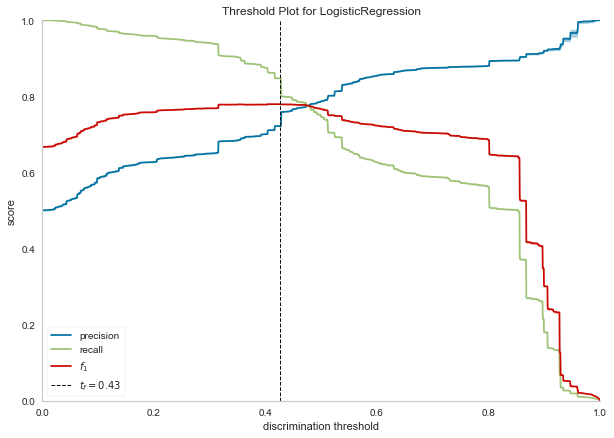

In [79]:
print(color.BOLD, 'Sensitivity_Specificity_Support: ', color.END, sensitivity_specificity_support(y_test, y_pred_smt, average='weighted')) #Sensitivity (ratio TP / (TP + FN) - quantifies the ability to avoid false negatives)
print(color.BOLD, 'Recall Score: ', color.END, recall_score(y_test, y_pred_smt)) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, precision_score(y_test, y_pred_smt))
print(color.BOLD, 'Accuracy Score: ', color.END, accuracy_score(y_test, y_pred_smt))
print(color.BOLD, 'F1 Score: ', color.END, f1_score(y_test, y_pred_smt))

# Instantiate the classification model and visualizer
figsize=(10, 7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(pipeline, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

visualizer.fit(X_train_smt, y_train_smt)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data

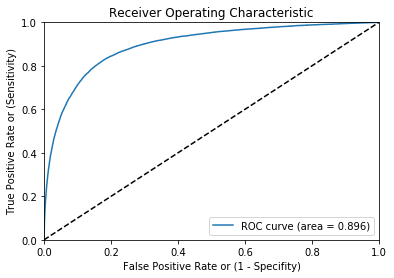

In [50]:
# Plotting ROC curve for SMOTETomek + Logistic Regression Model
y_pred_smt_proba = logreg.predict_proba(X_test)
y_pred_smt_proba[:5]
def plot_roc_curve(y_test, y_pred_smt_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_smt_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plot_roc_curve(y_test, y_pred_smt_proba)

  Train Time: 2535.777s 
[[149458  31102]
 [  3938  17937]]


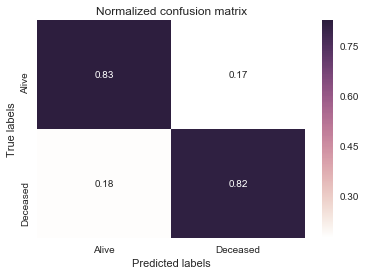

In [30]:
# Resampling Data Set: SMOTEENN (Over + Under Sampling) algorithm + Logistic Regression
sme = SMOTEENN(random_state=42)
t0 = time()
X_train_sme, y_train_sme = sme.fit_sample(X_train, y_train)
#Saving resampled data to a csv file for later access
#df_X = pd.DataFrame(X_train_sme)
#df_X.to_csv("11_ResampledData_X_train.csv", encoding='utf-8', index=False)
#df_y = pd.DataFrame(y_train_sme)
#df_y.to_csv("11_ResampledData_y_train.csv", encoding='utf-8', index=False)
logreg = LogisticRegression(C=1)
logreg.fit(X_train_sme, y_train_sme)
train_time_sme = time() - t0
print(color.BOLD, color.BLUE, "Train Time: %0.3fs" % train_time_sme, color.END)
y_pred_sme = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred_sme)
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
cm1 = (cm.astype(np.float64) / cm.sum(axis=1, keepdims=1))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(cm1, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Normalized confusion matrix'); 
ax.xaxis.set_ticklabels(['Alive', 'Deceased']); ax.yaxis.set_ticklabels(['Alive', 'Deceased']);
print(cm)

 Sensitivity_Specificity_Support:   (0.8269074023760713, 0.8208167497854578, None)
 Recall Score:   0.8199771428571428
 Precision Score:   0.3657701013479068
 Accuracy Score:   0.8269074023760713
 F1 Score:   0.5058803621287756


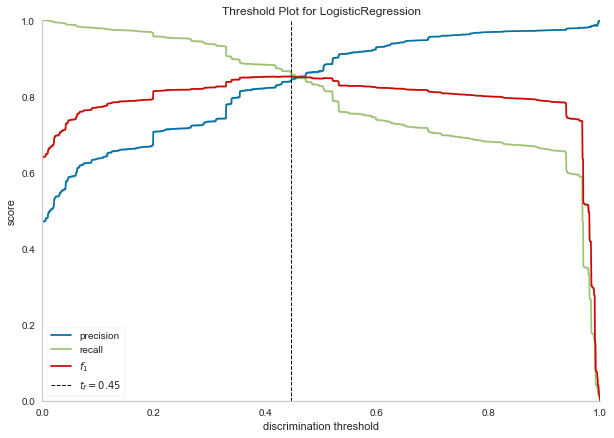

In [80]:
print(color.BOLD, 'Sensitivity_Specificity_Support: ', color.END, sensitivity_specificity_support(y_test, y_pred_sme, average='weighted')) #Sensitivity (ratio TP / (TP + FN) - quantifies the ability to avoid false negatives)
print(color.BOLD, 'Recall Score: ', color.END, recall_score(y_test, y_pred_sme)) #The recall score is the ability of the classifier to find all the positive samples
print(color.BOLD, 'Precision Score: ', color.END, precision_score(y_test, y_pred_sme))
print(color.BOLD, 'Accuracy Score: ', color.END, accuracy_score(y_test, y_pred_sme))
print(color.BOLD, 'F1 Score: ', color.END, f1_score(y_test, y_pred_sme))

# Instantiate the classification model and visualizer
figsize=(10, 7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = DiscriminationThreshold(pipeline, ax=ax, n_trials=10, exclude="queue_rate")
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

visualizer.fit(X_train_sme, y_train_sme)  # Fit the training data to the visualizer
visualizer.poof()     # Draw the data

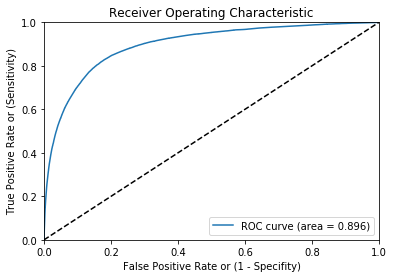

In [53]:
# Plotting ROC Curve for SMOTEENN + Logistic Regression Model
y_pred_sme_proba = logreg.predict_proba(X_test)
y_pred_sme_proba[:5]
def plot_roc_curve(y_test, y_pred_sme_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sme_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plot_roc_curve(y_test, y_pred_sme_proba)

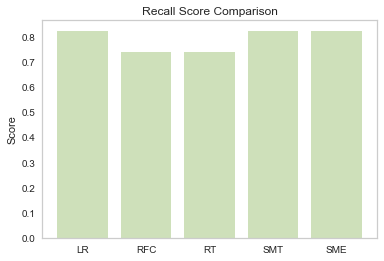

In [76]:
# Saving recall score (rs) of all models into a variable to plot the bar charts for comparison
lr_rs=recall_score(y_test, y_pred_lr)
rfc_rs=recall_score(y_test, y_pred_rf)
rt_rs=recall_score(y_test, y_pred_rt_1)
smt_rs=recall_score(y_test, y_pred_smt)
sme_rs=recall_score(y_test, y_pred_sme)

objects = ('LR', 'RFC', 'RT', 'SMT', 'SME')
y_pos = np.arange(len(objects))
performance = [lr_rs, rfc_rs, rt_rs, smt_rs, sme_rs]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Recall Score Comparison')
plt.grid(False)
 
plt.show()

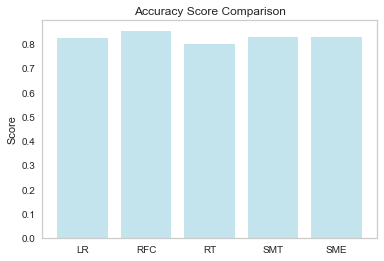

In [81]:
# Saving accurancy score (as) of all models into a variable to plot the bar charts for comparison
lr_as=accuracy_score(y_test, y_pred_lr)
rfc_as=accuracy_score(y_test, y_pred_rf)
rt_as=accuracy_score(y_test, y_pred_rt_1)
smt_as=accuracy_score(y_test, y_pred_smt)
sme_as=accuracy_score(y_test, y_pred_sme)

objects = ('LR', 'RFC', 'RT', 'SMT', 'SME')
y_pos = np.arange(len(objects))
performance = [lr_as, rfc_as, rt_as, smt_as, sme_as]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='c')
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Accuracy Score Comparison')
plt.grid(False)
 
plt.show()

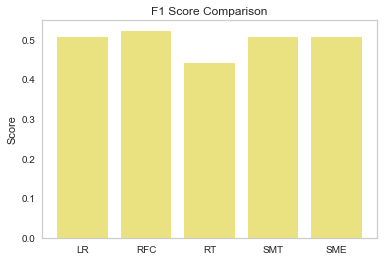

In [82]:
# Saving f1 score (as) of all models into a variable to plot the bar charts for comparison
lr_fs=f1_score(y_test, y_pred_lr)
rfc_fs=f1_score(y_test, y_pred_rf)
rt_fs=f1_score(y_test, y_pred_rt_1)
smt_fs=f1_score(y_test, y_pred_smt)
sme_fs=f1_score(y_test, y_pred_sme)

objects = ('LR', 'RFC', 'RT', 'SMT', 'SME')
y_pos = np.arange(len(objects))
performance = [lr_fs, rfc_fs, rt_fs, smt_fs, sme_fs]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='y')
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('F1 Score Comparison')
plt.grid(False)
 
plt.show()

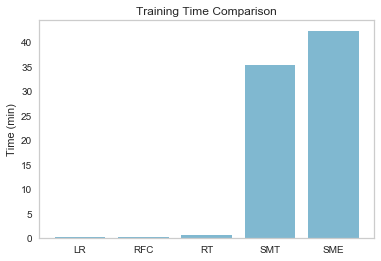

In [83]:
# Comparing Training time
objects = ('LR', 'RFC', 'RT', 'SMT', 'SME')
y_pos = np.arange(len(objects))
performance = [train_time_lr/60, train_time_rf/60, train_time_rt/60, train_time_smt/60, train_time_sme/60]
 
plt.bar(y_pos, performance, align='center', alpha=0.5, color='b')
plt.xticks(y_pos, objects)
plt.ylabel('Time (min)')
plt.title('Training Time Comparison')
plt.grid(False)
 
plt.show()

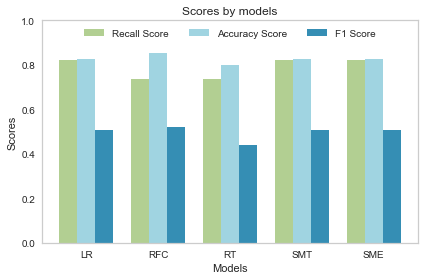

In [84]:
# Comparing Recall and Accuracy Scores for each model
n_groups = 5
rec_sc = [lr_rs, rfc_rs, rt_rs, smt_rs, sme_rs]
acc_sc = [lr_as, rfc_as, rt_as, smt_as, sme_as]
f1_sc = [lr_fs, rfc_fs, rt_fs, smt_fs, sme_fs]
 
# Creating the plot
figsize=(14, 10)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, rec_sc, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Recall Score')
 
rects2 = plt.bar(index + bar_width, acc_sc, bar_width,
                 alpha=opacity,
                 color='c',
                 label='Accuracy Score')

rects3 = plt.bar(index + bar_width + bar_width, f1_sc, bar_width,
                 alpha=opacity,
                 color='b',
                 label='F1 Score')
 
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.title('Scores by models')
plt.xticks(index + bar_width, ('LR', 'RFC', 'RT', 'SMT', 'SME'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
plt.grid(False)
 
plt.tight_layout()
plt.show()

In [ ]:
# Pickling Logistic Regression Model
label = "Mortality Logistic Regression"
outpath = label.lower().replace(" ", "-") + ".pickle"
with open(outpath, 'wb') as f:
    pickle.dump(lr, f)

In [63]:
# Predicting a new observation
user_input = {'age':77, 'sex':1, 'ms':'2', 'educ':'8', 'pob':'104', 'esr':'5', 'urban':'1', 'ssnyn':0, 'vt':0, 'histatus':1, 'hitype': '4'}
def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(40)
    # set the numerical input as they are
    enc_input[0] = data['age']
    enc_input[1] = data['sex']
    enc_input[2] = data['urban']
    enc_input[3] = data['ssnyn']
    enc_input[4] = data['vt']
    enc_input[5] = data['histatus']
    ##################### Marital Status ####################
    # get the array of marital status
    ms = df.ms.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'ms_'+data['ms']
    # search for the index in columns name list 
    ms_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[ms_column_index] = 1
    ##################### Education ####################
    # get the array of education
    educ = df.educ.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'educ_'+data['educ']
    # search for the index in columns name list 
    educ_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[educ_column_index] = 1
    ##################### POB ####################
    # get the array of place of birth
    pob = df.pob.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'pob_'+data['pob']
    # search for the index in columns name list 
    pob_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[pob_column_index] = 1
    ##################### Employment Status ####################
    # get the array of employment status
    esr = df.esr.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'esr_'+data['esr']
    # search for the index in columns name list 
    esr_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[esr_column_index] = 1
    ##################### Health Insurance Type ####################
    # get the array of HI Type
    hitype = df.hitype.unique()
    # redefine the the user inout to match the column name
    redefinded_user_input = 'hitype_'+data['hitype']
    # search for the index in columns name list 
    hitype_column_index = X.columns.tolist().index(redefinded_user_input)
    # fullfill the found index with 1
    enc_input[hitype_column_index] = 1
    return enc_input

In [64]:
print(input_to_one_hot(user_input))

[77.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  1.  0.]


In [66]:
a = input_to_one_hot(user_input)
a = a.reshape(1, -1)

In [68]:
from sklearn.externals import joblib
joblib.dump(lr, 'mortality-logistic-regression.pkl')

['mortality-logistic-regression.pkl']

In [69]:
lr = joblib.load('mortality-logistic-regression.pkl')
mort = lr.predict_proba(a)
mort = np.around(mort, 2)
print("Probability of 11-year mortality is", mort[0,1])

Probability of 11-year mortality is 0.87


Check out live Mortality Predictor web app based on the pickled logistic regression model at this URL: https://mortality-predictor.herokuapp.com/!